<a href="https://colab.research.google.com/github/Christian-Stefan/Team-Internship/blob/Chris/ContextModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

## Data Curation

In [7]:
# 1. Importing Data.csv
data = pd.read_csv('Data.csv')

# 2. Eliminating CTs which have no nodule slices
data["slices_present"] = data["slices_present"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
data = data[data['slices_present'].apply(lambda x: len(x) > 0)]
print((data['slices_present'].apply(len) == 0).sum()) # No zero-slices CTs
print(len(data)) # The number of fields slightly decreased

0
1453


## Encoding Labels

In [8]:
# 3. Encoding labels
label = LabelEncoder()
data['label'] = label.fit_transform(data['nodule_name'])
label_map = dict(zip(label.classes_, label.transform(label.classes_)))
print(label_map)

{'Active Infection': 0, 'Adenocarcinoma': 1, 'Adenoid Cystic Carcinoma': 2, 'Bronchioloalveolar Hyperplasia': 3, 'Carcinoid Tumors': 4, 'Granuloma': 5, 'Hamartoma': 6, 'Intrapulmonary Lymph Nodes': 7, 'Large Cell (Undifferentiated) Carcinoma': 8, 'Lymphoma': 9, 'Metastatic Tumors': 10, 'Sarcoidosis': 11, 'Sarcomatoid Carcinoma': 12, 'Small Cell Lung Cancer (SCLC)': 13, 'Squamous Cell Carcinoma': 14}


## Volume input preprocessing and construction

Start processing data from.../content/drive/MyDrive/TeamInternship/20241221_074106
Before norm, standard and rescale ------- Image size: (512, 512) 
Image type <class 'numpy.ndarray'>,
 (1300, 0)
After norm, standard and rescale -------- Image size: (224, 224, 1) 
Image type <class 'numpy.ndarray'>,
 Normalized: (0.9285714, 0.0)


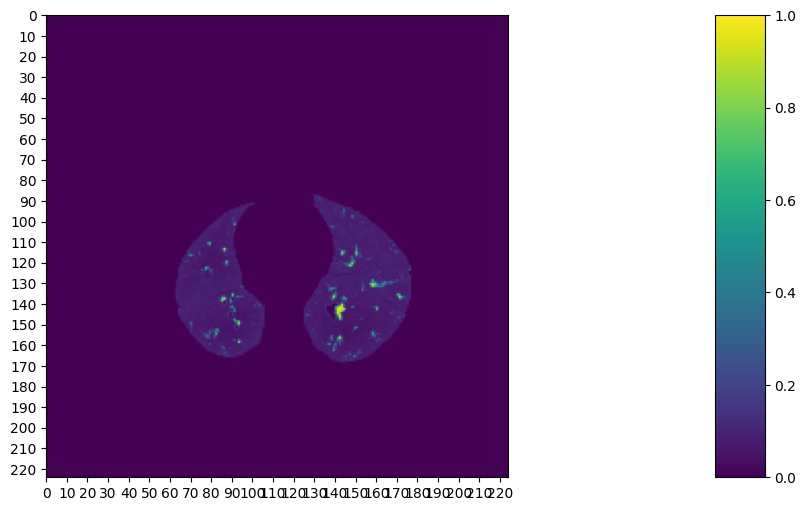

{'img': array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32), 'label': 'Small Cell Lung Cancer (SCLC)'}


In [9]:
from drive.MyDrive.TeamInternship.D_P_P import Preprocessing

#4. Preprocess lungs
processing = Preprocessing(Root_path="/content/drive/MyDrive/TeamInternship/20241221_074106",
                         Output_path="/content/Output")
dcm_collected_data = processing.get_slice_and_coordnates_Paths()

processing.preprocess_Data(dcm_collected_data,
                           plot=False,
                           save=True,
                           segment=False)

# 5. Initialize the sitk class - ImageSeriesReader - to create suitable objects for lung's slices and labels
sample_path:str = '/content/Output/LIDC-IDRI-0000/LungLIDC-IDRI-0000_1-0053.dcm'
dicom_files = pydicom.dcmread(sample_path)
img_context = dicom_files.pixel_array.astype(np.int16)
print("Before norm, standard and rescale ------- Image size:",img_context.shape,f"\nImage type {type(img_context)},\n {img_context.max(), img_context.min()}")

# 5.1 Convert to Hounsfield Units (HU)
intercept = dicom_files.RescaleIntercept
slope = dicom_files.RescaleSlope
hu_image = slope*img_context+intercept

# 5.2. Clip to lung window [-1000, 400]
hu_image = np.clip(hu_image, -1000, 400)

# 5.3. Normalize to [0, 1]
normalized = (hu_image+1000)/1400.0

# 5.4 Reisze to (224,224)
resized = cv2.resize(normalized, (224, 224), interpolation=cv2.INTER_LINEAR)

# 5.3 Add channel dimmension for grayscale
channeled_image = np.expand_dims(resized, axis=-1).astype(np.float32)
print("After norm, standard and rescale -------- Image size:",channeled_image.shape,f"\nImage type {type(channeled_image)},\n Normalized: {channeled_image.max(), channeled_image.min()}")

fig = plt.figure(figsize=(10,6))
plt.imshow(channeled_image)
plt.xticks(np.arange(-0.5, channeled_image.shape[0]+1, 10), labels=np.arange(0, channeled_image.shape[0]+1, 10))
plt.yticks(np.arange(-0.5, channeled_image.shape[1]+1, 10), labels=np.arange(0, channeled_image.shape[1]+1, 10))
plt.clim([0,1])
cbar_ax = fig.add_axes([0.95, .11, 0.05, 0.77])
plt.clim([0, 1])
plt.colorbar(cax=cbar_ax)
plt.show()

# 6. Craft a dictionary that can encompass both, the image itself and associated label: {'img': numpy.ndarray, 'label': ...}
import json
json_path:str = "/content/Output/LIDC-IDRI-0000/segmentation_00000.json"
with open(json_path, 'r') as f:
  json_annotation = json.load(f)

label = json_annotation['characteristics'][0]['nodule_name']
prepared_sample = {'img':channeled_image,'label':label}

print(prepared_sample)

There will be 784 patches, each 8 by 8.




IndexError: index 81 is out of bounds for axis 0 with size 81

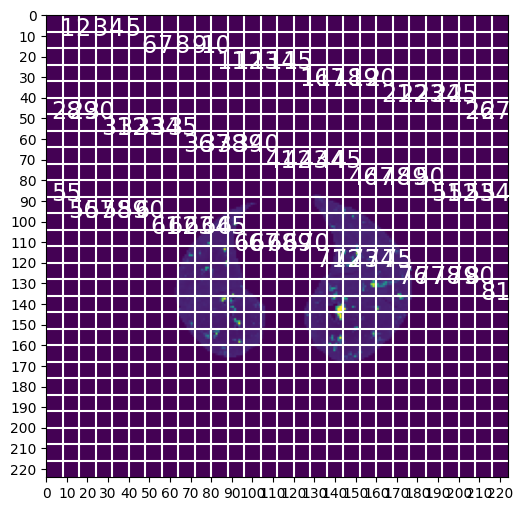

In [10]:
# 1. Transform an image into patches;
P = 8 # Pixel-Size for each patch
N = int((prepared_sample['img'].shape[0]*prepared_sample['img'].shape[1])/(P**2))
print('There will be', N, 'patches, each', P, 'by', str(P)+'.')
print('\n')

fig = plt.figure(figsize=(13,6))
plt.imshow(prepared_sample['img'])
plt.hlines(np.arange(P, prepared_sample['img'].shape[0], P)-0.5, -0.5, prepared_sample['img'].shape[1]-0.5, color='w')
plt.vlines(np.arange(P, prepared_sample['img'].shape[1], P)-0.5, -0.5, prepared_sample['img'].shape[0]-0.5, color='w')
plt.xticks(np.arange(-0.5, prepared_sample['img'].shape[1]+1, 10), labels=np.arange(0, prepared_sample['img'].shape[1]+1, 10))
plt.yticks(np.arange(-0.5, prepared_sample['img'].shape[0]+1, 10), labels=np.arange(0, prepared_sample['img'].shape[0]+1, 10))
x_text = np.tile(np.arange(9.5, prepared_sample['img'].shape[1], P), 3)
y_text = np.repeat(np.arange(9.5, prepared_sample['img'].shape[0], P), 5)
for i in range(1, N+1):
    plt.text(x_text[i-1], y_text[i-1], str(i), color='w', fontsize='xx-large', ha='center')
plt.text(x_text[2], y_text[2], str(3), color='k', fontsize='xx-large', ha='center');

## ViT Initialization

### Input Embedding Block Initialization
Heavily relies on the patching procedure which practically means to transform the image into a flatten vector where each item represents a certain slice (e.g., 20x20 pixels) dislocated from that image;

In [11]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor

class PatchEmbedding(nn.Module):
  """
  Class meant to break down an entire image in tokens of size (W:patch_size, H:patch_size)
  and flat those at the level of a one-dimensional vector;
  """
  def __init__(self,
               in_channels:int = 1, # Binary immage
               patch_size = 8, # Dimension of one patch
               emb_size = 128):

    self.patch_size = patch_size
    super().__init__()

    self.projection = nn.Sequential(
        # Breaks down the image in s1 s2 patches and flat them
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
                  p1=patch_size,
                  p2=patch_size),
        nn.Linear(patch_size* patch_size *in_channels, emb_size)
    )

  def forward(self, x:Tensor)->Tensor:
    x = self.projection(x)
    return x

### -- Example --- ###
img = torch.from_numpy(prepared_sample['img']).permute(2, 0, 1).unsqueeze(0).to(torch.float32)
print("Initial shape:",img.shape)
embedding = PatchEmbedding()(img)
print("Patch shape: ", embedding.shape)

Initial shape: torch.Size([1, 1, 224, 224])
Patch shape:  torch.Size([1, 784, 128])


### Position Embedding
Initially field randomly learnable vector which later one is meant to represent an overall weight of a flattened patch - global feature extraction. This positional embedding also makes the model better undertand where each slice had its place in the image
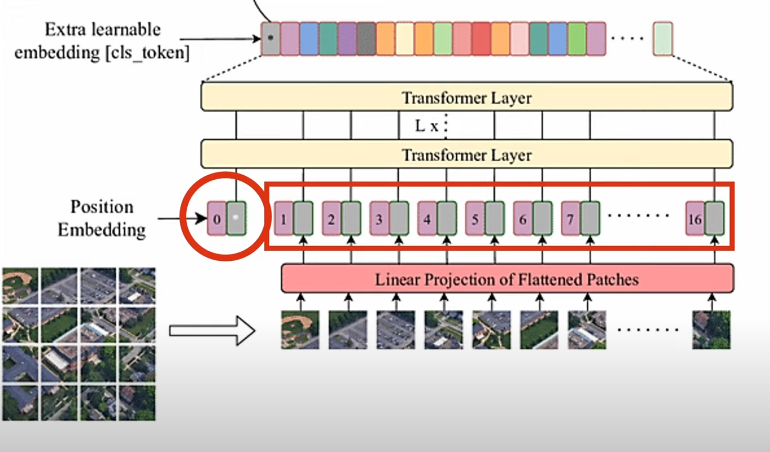

### Multi-Head Attention
It heavily relies on a suit of keys - q, k and v

In [12]:
from einops import rearrange

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

### Layer Norm
Add Layer normalization

In [13]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

###Linear layer


In [14]:
class FeedForward(nn.Sequential):
  def __init__(self, dim, hidden_dim, dropout = 0.):
    super().__init__(
        nn.Linear(dim, hidden_dim),
        nn.GELU(), # Activation function GELU - Hyperparam 1
        nn.Dropout(dropout), # Dropout to avoid overfitting - Hyperparam 2
        nn.Linear(hidden_dim,dim),
        nn.Dropout(dropout))

### Residuals
Preventing vanishing gradient problem

In [15]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

## ViT Prototype

In [38]:
from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=1, img_size=224, patch_size=4, emb_dim=32,
                n_layers=6, out_dim=3, dropout=0.1, heads=2):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])


model = ViT()
print(model)
model(torch.ones((1,1, 224,224)))

ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=16, out_features=32, bias=True)
    )
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=32, out_featu

tensor([[ 0.5622, -0.2869, -0.8667]], grad_fn=<AddmmBackward0>)

# Training
## Normalisation and Loader-conversion
For all the samples located in IDRI 0000, 0637, 0644

In [39]:
class pipeline_norm_Extension(Preprocessing, Dataset):

    def __init__(self, Root_path, Output_path):
        super().__init__(Root_path, Output_path)
        self.data_container: list = []
        self.Output_path = Output_path
        self.label2idx: dict = {}

        # 1. Run preprocessing
        dcm_collected_data = self.get_slice_and_coordnates_Paths()
        self.preprocess_Data(dcm_collected_data, plot=False, save=True, segment=False)

        label_set = set()

        # 2. Load data
        for folder_name in os.listdir(self.Output_path):
            folder_path = os.path.join(self.Output_path, folder_name)
            if os.path.isdir(folder_path) and folder_name.startswith("LIDC-IDRI"):
                print(f"📁 Scanning folder: {folder_name}")
                label = ''  # reset label

                # Loop through DICOMs for segmentation...json
                for file in os.listdir(folder_path):
                    if 'segmentation' in file:
                        with open(os.path.join(folder_path, file), 'r') as f:
                            json_annotation = json.load(f)
                        label = json_annotation['characteristics'][0]['nodule_name']
                        label_set.add(label)
                        break

                # Loop through DICOMs for SLICES/LUNGS..dcm
                for file in os.listdir(folder_path):
                    if 'LIDC-IDRI' in file and file.endswith('.dcm'):
                        dicom_files = pydicom.dcmread(os.path.join(folder_path, file))
                        img_context = dicom_files.pixel_array.astype(np.int32)

                        # HU conversion
                        intercept = dicom_files.RescaleIntercept
                        slope = dicom_files.RescaleSlope
                        hu_image = slope * img_context + intercept

                        # Normalize
                        hu_image = np.clip(hu_image, -1000, 400)
                        normalized = (hu_image + 1000) / 1400.0
                        resized = cv2.resize(normalized, (224, 224), interpolation=cv2.INTER_LINEAR)
                        channeled_image = np.expand_dims(resized, axis=-1).astype(np.float32)

                        # Add sample + label
                        if label != '':
                            prepared_sample = {'img': channeled_image, 'label': label}
                            self.data_container.append(prepared_sample)

        # Finalize label-to-index mapping
        self.label2idx = {label: idx for idx, label in enumerate(sorted(label_set))}

    def __len__(self):
        """
        Custom function that builts-in a `len` feature for our current class to determine
        the length of data_container container returned by the constructor

        """
        return len(self.data_container)

    def __getitem__(self, idx):
      """
      Each time an item is retrieved from an object/instance of this class it will pass through the bellow
      cascade of actions to make a tensor out of it eventually;

      """
      item = self.data_container[idx]
      img = torch.from_numpy(item['img']).permute(2, 0, 1).float()  # shape: (1, 224, 224)
      label = torch.tensor(self.label2idx[item['label']], dtype=torch.long)

      return img, label

data = pipeline_norm_Extension("/content/drive/MyDrive/TeamInternship/20241221_074106",
                               "/content/Output/")

Start processing data from.../content/Output/
📁 Scanning folder: LIDC-IDRI-0000
📁 Scanning folder: LIDC-IDRI-0637
📁 Scanning folder: LIDC-IDRI-0644


## Training

## What the input looks like after pipe_line_norm_Extentsion

In [31]:
# Classes/Labels
classes_container:set = set()
debug_dataLoader = DataLoader(data, batch_size=1, shuffle = False)

for outputs, labels in debug_dataLoader:
  if hasattr(labels, 'item'):
    classes_container.add(labels.item())

print(classes_container)

{0, 1, 2}


## Actual Training

In [40]:
# 1. Spliting the dataset
train_len = int(0.8 * len(data))
test_len = len(data) - train_len
train_dataset, test_dataset = random_split(data, [train_len, test_len])
print("Len:",len(train_dataset), len(test_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True)


# 2. Initializing the training
device = "cuda"
model = ViT().to(device)

optimizer = optim.AdamW(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

# Containers
loss_over_epochs_train:list = [] # container storing loss
loss_over_epochs_test:list = []
accuracy_over_epochs_train:list = [] # container storing accuracy-avg/epoch
accurac_over_epochs_test:list = []

for epoch in range(50):
    epoch_losses:list = []
    correct_preds = 0
    total_samples = 0

    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

        # Accuracy
        preds = torch.argmax(outputs, dim=1)
        correct_preds += (preds == labels).sum().item()
        total_samples += labels.size(0)

    train_accuracy = correct_preds / total_samples
    print(f">>> Epoch {epoch} train loss: {np.mean(epoch_losses):.4f}, accuracy: {train_accuracy:.4f}")

    # --- Evaluation ---
    epoch_losses = []
    correct_preds = 0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for step, (inputs, labels) in enumerate(test_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_losses.append(loss.item())

            preds = torch.argmax(outputs, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

    test_accuracy = correct_preds / total_samples
    print(f">>> Epoch {epoch} test loss: {np.mean(epoch_losses):.4f}, accuracy: {test_accuracy:.4f}")

Len: 9 3
>>> Epoch 0 train loss: 1.2060, accuracy: 0.4444
>>> Epoch 0 test loss: 1.4877, accuracy: 0.0000
>>> Epoch 1 train loss: 1.1776, accuracy: 0.4444
>>> Epoch 1 test loss: 1.4763, accuracy: 0.0000
>>> Epoch 2 train loss: 1.0742, accuracy: 0.4444
>>> Epoch 2 test loss: 1.4611, accuracy: 0.0000
>>> Epoch 3 train loss: 1.0997, accuracy: 0.4444
>>> Epoch 3 test loss: 1.4421, accuracy: 0.0000
>>> Epoch 4 train loss: 1.1392, accuracy: 0.4444
>>> Epoch 4 test loss: 1.4405, accuracy: 0.0000
>>> Epoch 5 train loss: 1.0598, accuracy: 0.4444
>>> Epoch 5 test loss: 1.4393, accuracy: 0.0000
>>> Epoch 6 train loss: 1.0504, accuracy: 0.4444
>>> Epoch 6 test loss: 1.4427, accuracy: 0.0000
>>> Epoch 7 train loss: 1.0250, accuracy: 0.4444
>>> Epoch 7 test loss: 1.4441, accuracy: 0.0000
>>> Epoch 8 train loss: 1.0184, accuracy: 0.4444
>>> Epoch 8 test loss: 1.4512, accuracy: 0.0000
>>> Epoch 9 train loss: 1.0076, accuracy: 0.4444
>>> Epoch 9 test loss: 1.4560, accuracy: 0.0000
>>> Epoch 10 train lo

# Fusion Model

## Context Branch

In [ ]:
class ContextBranch(nn.Module):
    def __init__(self):
        super().__init__() # Constructor to initialize the `upper` constructor/pervious constructor? Why?
        self.conv = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2),  # (7,256,256) → (3,128,128)

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1))  # output: [B, 32, 1, 1, 1]
        )

    def forward(self, x):
        x = self.conv(x)
        return x.view(x.size(0), -1)  # [B, 32]

## Radiomics Branch

In [ ]:
class RadiomicsBranch(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

    def forward(self, x):
        return self.fc(x)

## Local Branch

In [ ]:
class LocalBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2),  # (5,64,64) → (2,32,32)

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1))  # output: [B, 32, 1, 1, 1]
        )

    def forward(self, x):
        x = self.conv(x)
        return x.view(x.size(0), -1)  # flatten to [B, 32]

# Model Header

In [ ]:
class TripleFusionModel(nn.Module):
    def __init__(self, num_classes, radiomics_dim=25):
        self.local_branch = LocalBranch()
        self.context_branch = ContextBranch()
        self.radiomics_branch = RadiomicsBranch(radiomics_dim)

        self.classifier = nn.Sequential(
            nn.Linear(32 + 32 + 32, 64),  # fuse outputs
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, volume_local, volume_context, radiomics):
        local_feat = self.local_branch(volume_local)
        context_feat = self.context_branch(volume_context)
        radio_feat = self.radiomics_branch(radiomics)

        fused = torch.cat([local_feat, context_feat, radio_feat], dim=1)
        out = self.classifier(fused)
        return out

# Model Selection

## Particle Swarm Optimization (PSO) - Hyperparameter Optimization Initialization & Explanation

In Particle Swarm Optimization (PSO), **particles** represent candidate solutions—for example, a randomly initialized set of hyperparameters for a machine learning model.

- Each particle moves within a **D-dimensional bounded continuous search space**.
- Particles collaborate to discover the optimal solution (i.e., the hyperparameter combination that minimizes a loss function).

Each particle \( i \) is defined by three key vectors at each iteration \( t \):

- **Position**: $\mathbf{x}_i(t) \in \mathbb{R}^D $ — current location of particle \( i \)
- **Velocity**: $mathbf{v}_i(t) \in \mathbb{R}^D $ — the movement direction and speed of particle \( i \)
- **Best Position**: $ \mathbf{b}_i(t) \in \mathbb{R}^D $— the best position found so far by particle \( i \) based on the fitness (e.g., validation loss)

### Position Update Rule

The new position is computed by adding the current velocity to the current position:

\[
$\mathbf{x}_i(t + 1) = \mathbf{x}_i(t) + \mathbf{v}_i(t)$
\]

### Velocity Update Rule (Conceptual Overview)

The velocity is influenced by:
- **Cognitive component**: Particle's own best-known position
- **Social component**: Best-known position among all particles (global best)

The combination of these two attractions causes particles to explore and exploit the search space, ideally converging on an optimal or near-optimal solution over iterations.


In [ ]:
import random as rd

best_position_container:list = [] # Keeps track of best position g(t) visited by any particple up to itteration t

# 1. Random initialization of particles/subsets of variants for hyperparameters (e.g., Learning Rate;	Optimizer; Loss Functios)
up_lr:float = 0.1 # Upper range of learning rate - initially
low_lr:float = 0.01 # Lower range of learning rate

optimizers:list = [ # Available optimizers in torch
    "Adadelta",
    "Adafactor",
    "Adagrad",
    "Adam",
    "AdamW",
    "SparseAdam",
    "Adamax",
    "ASGD",
    "LBFGS",
    "NAdam",
    "RAdam",
    "RMSprop",
    "Rprop",
    "SGD"
]

loss_functions:list = [
    "L1Loss",
    "MSELoss",
    "CrossEntropyLoss",
    "CTCLoss",
    "NLLLoss",
    "PoissonNLLLoss",
    "GaussianNLLLoss",
    "KLDivLoss",
    "BCELoss",
    "BCEWithLogitsLoss",
    "MarginRankingLoss",
    "HingeEmbeddingLoss",
    "MultiLabelMarginLoss",
    "HuberLoss",
    "SmoothL1Loss",
    "SoftMarginLoss",
    "MultiLabelSoftMarginLoss",
    "CosineEmbeddingLoss",
    "MultiMarginLoss",
    "TripletMarginLoss",
    "TripletMarginWithDistanceLoss"
]


hyperparameters_grid:dict = {
    'Learning_rate': [0.1, 0.01, 0.005, 0.0010, 0.00020], # rd.uniform(low_lr, up_lr),
    'Optimizer': optimizers, # optimizers[rd.randint(0, len(optimizers)-1)],
    'Loss Function': loss_functions # loss_functions[rd.randint(0, len(loss_functions)-1)]
}

### Particle initialization/estimator - Method

In [ ]:
def _init_Populaton():

  hyperparameters_grid:dict = {
    'Learning_rate': [0.1, 0.01, 0.005, 0.0010, 0.00020],
    'Optimizer': optimizers,
    'Loss Function': loss_functions
}
  return hyperparameters_grid

# Usage example - Initialize a population of 10 particles/individuals:
# for x in range(10):
#     particle = init_Populaton()
#     print(particle)

### Evaluate fitness - Method

In [ ]:
def evaluate_fitness(self,
                     X_train,
                     X_test,
                     y_train,
                     y_test,
                     hyperparameters):
        """
        Evaluate the fitness of a set of hyperparameters.

        Parameters:
            - estimator: The estimator object.
            - X_train: Training features.
            - X_test: Testing features.
            - y_train: Training labels.
            - y_test: Testing labels.
            - hyperparameters: The set of hyperparameters to evaluate.

        Returns:
            - score: The accuracy score of the estimator with the given hyperparameters.
        """
        # Unpack hyperparameters
        estimator_instance = self._create_estimator(hyperparameters)

        estimator_instance.fit(X_train, y_train)
        y_pred = estimator_instance.predict(X_test)
        accuracy_pso = accuracy_score(y_test, y_pred)
        return accuracy_pso

### Create the searching space - Method

In [ ]:
def pso_hyperparameter_optimization(self,
                                    X_train,
                                    X_test,
                                    y_train,
                                    y_test,
                                    num_particles,
                                    num_iterations,
                                    c1 = 2.05,
                                    c2 = 2.05,
                                    num_jobs=-1,
                                    w=0.72984):
        """
        Perform hyperparameter optimization using Particle Swarm Optimization (PSO).

        Parameters:
            - estimator: The estimator object (e.g., KNeighborsClassifier, ViT).
            - data: The dataset.
            - target_column_index: Index of the target column in the dataset.
            - num_particles: Number of particles in the population.
            - num_iterations: Number of iterations for the PSO algorithm.
            - c1: Acceleration constant. Default value is c1 = 2.05
            - c2: Acceleration constant. Default value is c2 = 2.05
            - num_jobs: Number of parallel jobs for fitness evaluation.
            - inertia weight: Inertia constant. Default value is w=0.72984 according to the paper by M. Clerc and J. Kennedy

        Returns:
            - global_best_position: The best set of hyperparameters found.
            - global_best_fitness: The best accuracy found.
        """
        if self.random_seed is not None:
            np.random.seed(self.random_seed)

        # 1. Initialize the population of particles
        hyperparameter_space = self._init_Populaton()
        progress_bar = tqdm(total=num_iterations, desc="PSO Progress")
        population:list = [] # Container 1: Population

        for _ in range(self.num_particles):
            hyperparameters = [np.random.choice(hyperparameter_space[param]) for param in hyperparameter_space]
            population.append(hyperparameters)


        # 2. Initialize velocity and best position
        velocity = [[0] * len(hyperparameter_space) for _ in range(num_particles)] # Container 2: Velocity, of each hyperparameter-set stays zero at initialization phase
        best_position = population.copy() # Container 3: Best position do not differ from population
        global_best_fitness = -float("inf") # Conainer 4: Best positions are all the same across individuals hence fitness stays constant
        global_best_position = [] # Container 5: Best position a given individual has ever reached




        # PSO optimization loop
        for _ in range(num_iterations):
            fitness = Parallel(n_jobs=num_jobs)(
                delayed(self.evaluate_fitness)(X_train, X_test, y_train, y_test, particle)
                for particle in population
            )





# Dependencies

In [19]:
# !pip install pydicom
# !pip install SimpleITK
# !pip install tensorflow

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, classification_report, precision_score
import pandas as pd
import ast
from sklearn.preprocessing import LabelEncoder
import SimpleITK as sitk
import time as t
import numpy as np
import matplotlib.pyplot as plt
import json, glob, re, os, pydicom
from skimage.draw import polygon
from skimage.filters import threshold_otsu
from skimage.morphology import disk
from scipy.ndimage import binary_fill_holes,label,binary_dilation,binary_erosion, binary_closing
from ipywidgets import interact
import cv2
import shutil
import tensorflow as tf
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, random_split